In [1]:
import numpy as np
import tensorflow.keras.backend as backend 
import io
import os
import urllib
import zipfile
import time 
import boto3
import boto.s3
import sys
import json
from orion import Orion
import logging
import pickle
from typing import List, Union
import pandas as pd
from mlblocks import MLPipeline
from orion.evaluation import CONTEXTUAL_METRICS as METRICS
from orion.evaluation import contextual_confusion_matrix
from orion.evaluation import contextual_accuracy
from orion.evaluation import contextual_f1_score
from orion.evaluation import contextual_precision
from orion.evaluation import contextual_recall

# IMPORTANT: 
# Requires editting out the __all__ file property in orion.evaluation.__init__.py file
# so that true_positives are readily available to be accessed and creating a contextual_true_positives method 
# to return the TP's in the contextual matrix
from orion.evaluation import contextual_true_positives

# IMPORTANT: 
# Requires creating a credentials/permisions file for accessing S3 bucket
# named credentials.txt

# IMPORTANT:
# Requires a datasets_names.csv file with the timeseries anomalies datasets names in the first column
# and a tuple of all relevant signal names that are present in that dataset
# For example: 
# First cell would be SMAP, followed by the tuple in the next column/same row: ('P-1', 'S-1', 'E-1', 'E-2', ...)
# See further below in method get_dataset_name_for_signal()
from functools import partial
from orion.data import load_signal, load_anomalies
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import ast 

# Use matplotlib version 3.2.1 compatible with numpy 1.16.6 for ORION
S3_URL = 'https://d3-ai-orion-analysis.s3.amazonaws.com/'
BUCKET = "d3-ai-orion-analysis"

In [2]:

def build_df(data, start=0):
    index = np.array(range(start, start + len(data)))
    step = 300
    initial_time = 1222819200 
    timestamp = index * step + initial_time 
    return pd.DataFrame({'timestamp': timestamp}, dtype='int64')
def time_index(index):
    step = 300
    initial_time = 1222819200
    return index * step + initial_time

In [3]:
def get_creds():    
    credentials_file = "credentials_file.txt" #some path to the credentials/permisions file for accessing S3 bucket 
    with open(credentials_file) as file:
        lines = file.readlines()
        ACCESS_KEY_ID_LINE_NUM = 2
        SECRET_ACCESS_KEY_ID_LINE_NUM = 3
        access_key_id = lines[ACCESS_KEY_ID_LINE_NUM]
        secret_access_key = lines[SECRET_ACCESS_KEY_ID_LINE_NUM]
        
        access_key_id = access_key_id.replace("\n", "")
        secret_access_key = secret_access_key.replace("\n", "")
    return access_key_id, secret_access_key    
    
def send_file_to_s3(file_path, file_name): 
    # Creating Session With Boto3.
    # Creating S3 Resource From the Session.
    # Fetch S3 credentials from credentials file
    print("Sending file {file_name} to S3".format(file_name=file_name))
    access_key_id, secret_access_key = get_creds()
    s3 = boto3.Session(
        aws_access_key_id = access_key_id,
        aws_secret_access_key = secret_access_key
    ).resource('s3')

    result = s3.Bucket(BUCKET).upload_file(file_path, file_name)


In [4]:
def load_anomalies_from_s3():
    file_name = 'anomalies.csv'
    # Fetch S3 credentials from credentials file
    file_content = pd.read_csv(S3_URL + file_name, index_col=False)
    
    return file_content

In [5]:
def load_file_from_s3(s3_file_name, dai_desk=False):
    
    # Creates local file path to load from
    file_epoch_ending = s3_file_name.split("/")[1]

    PREFIX_AFTER_EPOCH_STR = 8
    INDEX_BEFORE_EXT = -4
    #     file_type = file_epoch_ending[PREFIX_AFTER_EPOCH_STR:INDEX_BEFORE_EXT]
    file_type = file_epoch_ending.split("_")[2]
    
    if dai_desk: 
        s3_file_name = s3_file_name.replace("/", "")
        str_index = s3_file_name.rfind("_")
        s3_file_name = s3_file_name[ : str_index] + "-" + s3_file_name[str_index + 1 : ]
    
    if file_type == "anomalies.csv" or file_type == "report.csv":
        if not dai_desk:
            file_content = pd.read_csv(S3_URL + s3_file_name, index_col=False)
        else:
            file_content = pd.read_csv(s3_file_name, index_col=False)
        
    else : 
        if not dai_desk:
            # Fetch S3 credentials from credentials file    
            access_key_id, secret_access_key = get_creds()
            s3 = boto3.Session(
                aws_access_key_id = access_key_id,
                aws_secret_access_key = secret_access_key
            ).resource('s3')

            bucket = s3.Bucket(BUCKET)

            with open(s3_file_name[-4] + "-local_copy.pkl", 'wb') as data:
                bucket.download_fileobj(s3_file_name, data)

            with open(s3_file_name[-4] + "-local_copy.pkl", 'rb') as data:
                file_content = pickle.load(data)
        else:
            with open(s3_file_name, "rb") as dai_file:
                file_content = pickle.load(dai_file)
    
    return file_content

def delete_file_from_s3(file_name):
    
    access_key_id, secret_access_key = get_creds()
    s3 = boto3.Session(
        aws_access_key_id = access_key_id,
        aws_secret_access_key = secret_access_key
    ).resource('s3')
        
    return s3.Object(BUCKET, file_name).delete() # your-key is the signature of the object you want to delete

In [6]:
def get_ground_truth_anomalies(signal_name):
    anomalies = list()
    
    anomalies = load_anomalies_from_s3()
    signal_anomalies = anomalies[anomalies["signal"] == signal_name]
    # Might need to implement other way of retrieving anomalies
    return ast.literal_eval(signal_anomalies['events'].values[0])

In [7]:
def get_scores(orion, signal_name, original_time_series, gen_time_series, detected_anomalies):
    """
    Extract Confusion Matrix, F1 Scores and MSE from data
    """
    METRICS['confusion_matrix'] =  contextual_confusion_matrix
    
    metrics_overlap = METRICS.copy()
    
    metrics_overlap = {name + '_overlap': partial(fun, weighted=False) for name, fun in metrics_overlap.items()}

    metrics = {**METRICS, **metrics_overlap}
    # dict of {[name of fn] : fn itself}
    
    # scorer input
    # ground truth anomalies (from anomalies.csv in s3bucket)
    # detected anomalies (output of orion/pipeline)
    # data (signal)
    train_data = load_signal(signal_name)
    ground_truth_anomalies = get_ground_truth_anomalies(signal_name)
    data = train_data
    scores = {}
    for name, scorer in metrics.items():
        try:
            scores[name] = [scorer(ground_truth_anomalies, detected_anomalies, data)]
        except Exception as ex:
            scores[name] = 0
    data = pd.DataFrame(train_data["value"])
    
    mse = mean_squared_error(original_time_series, gen_time_series)
    scores["MSE"] = [mse]
    tp = contextual_true_positives(ground_truth_anomalies, detected_anomalies)
    scores["true_positives"] = tp
    return scores


def get_dataset_name_for_signal(signal_name):
    
    dataset_file_name = "datasets_names.csv"
    datasets_to_signals = dict()
    # This program assumes the csv file has a header. 
    # In case of missing header in the csv file, we have to pass it explicitly to the program
    csv_file = pd.DataFrame(pd.read_csv(dataset_file_name, sep = ",", header = None, index_col = False))
    csv_file.to_json("datasets.json", orient = "records", date_format = "epoch", double_precision = 10, force_ascii = True, date_unit = "ms", default_handler = None)
    
    with open("datasets.json") as f:
        json_list = json.load(f)
        
    for json_dict in json_list:
        dataset_name = json_dict['0'] 
        corresponding_signals = json_dict['1']
        
        datasets_to_signals[dataset_name] = corresponding_signals
    
    signals_to_datasets = dict()
    
    for dataset_name in datasets_to_signals.keys():
        formatted_signals_list = datasets_to_signals[dataset_name].replace('\'', '').replace('(', '').replace(')', '').replace(' ', '').split(',')
        for signal in formatted_signals_list:
            
            signals_to_datasets[signal] = dataset_name
    
    return signals_to_datasets[signal_name]
    

In [8]:
def send_anomalies_timeseries_scores(orion, signal_name, current_epoch, pkl_file_substring):
    train_data = load_signal(signal_name)
    
    anomalies, viz = orion.detect(train_data, visualization=True)
    
    gen_time_series = viz["generated_timeseries"]
    original_time_series = viz["original_timeseries"]
    
    # SAVE F1 Scores and MSEs using VIZ 
    # GET F1 SCORES using get_scores()
    scores = get_scores(orion, signal_name, original_time_series, gen_time_series, anomalies)
    print(scores, "THESE ARE THE SCORES!!")
    scores_df = pd.DataFrame.from_dict(scores)
    # Creates local file path to load from
    anomalies_path = pkl_file_substring + "epoch_{current_epoch}-anomalies.csv".format(current_epoch=current_epoch)
    gen_time_series_path = pkl_file_substring + "epoch_{current_epoch}-generated_timeseries.pkl".format(current_epoch=current_epoch)
    orion_path = pkl_file_substring + "epoch_{current_epoch}-orion.pkl".format(current_epoch=current_epoch)
    report_path = pkl_file_substring + "epoch_{current_epoch}-report.csv".format(current_epoch=current_epoch)
    
    # UPDATE EPOCH NUMBER PER NAMING 
    anomalies_file_name = pkl_file_substring + "/epoch_{current_epoch}_anomalies.csv".format(current_epoch=current_epoch)
    gen_time_series_file_name = pkl_file_substring + "/epoch_{current_epoch}_generated_timeseries.pkl".format(current_epoch=current_epoch)
    orion_file_name = pkl_file_substring + "/epoch_{current_epoch}_orion.pkl".format(current_epoch=current_epoch)
    report_file_name = pkl_file_substring + "/epoch_{current_epoch}_report.csv".format(current_epoch=current_epoch)    
    # Creates anomalies file so that it can be uploaded to S3
    anomalies.to_csv(anomalies_path, index=False)
    # Send Anomalies to S3
    send_file_to_s3(anomalies_path, anomalies_file_name)
        
    # Creates generated time series file so that it can be uploaded to S3
    with open(gen_time_series_path, 'wb') as new_file:
        pickle.dump(gen_time_series, new_file)
        # Send generated time series to S3
    send_file_to_s3(gen_time_series_path, gen_time_series_file_name)
    
    # Creates generated time series file so that it can be uploaded to S3
    with open(orion_path, 'wb') as new_file:
        pickle.dump(orion, new_file)
        # Send ORION pipeline to S3
    send_file_to_s3(orion_path, orion_file_name)
    
    # Send SCORE REPORT TO S3
    scores_df.to_csv(report_path, index=False)

    send_file_to_s3(report_path, report_file_name)
    
    return anomalies, gen_time_series, scores



In [9]:
# Variables
# Num Epochs
# Strat
def get_date_index():
    #     step = 300
    #     initial_time = 1222819200

    #     time_struct = time.localtime()
    #     month, day = time_struct.tm_mon, time_struct.tm_mday
    #     hour, minute, sec = time_struct.tm_hour, time_struct.tm_min, time_struct.tm_sec

    #     ## CONVERT TO INTEGER WITH TIME STAMP
    #     index = month * 30 * 3600 * 24 + day * 3600 * 24 + hour * 3600 + minute * 60 + sec 
    #     index = index % step
    #     date_index =  str(index * step + initial_time)
    date_index = int(time.time())

    return date_index

def create_pipeline_file_name(signal_name, pipeline_name, num_epochs, date_index):
    ### FOLDER NAME_PIPELINE NAME_SIGNAL NAME_DATASET NAME_NUMEPOCHS, DATESTAMP,  . pkl 
    dataset_name = get_dataset_name_for_signal(signal_name)
    pkl_file_name = "{pipeline_name}_num_epochs_{num_epochs}_{signal_name}_{dataset_name}_{date_index}".format(pipeline_name=pipeline_name, num_epochs=num_epochs, 
                    signal_name=signal_name, dataset_name=dataset_name,date_index=date_index)
    pkl_file_name += ".pkl"
    
    return pkl_file_name

def single_epoch_pipeline(num_epochs, pipeline_name, signal_name, s3_path = None):

    train_data = load_signal(signal_name)
    # FETCH TIME and then use it to create pipeline name 
    date_index = get_date_index()
    pkl_file_name = create_pipeline_file_name(signal_name, pipeline_name, num_epochs, date_index)
    new_path = os.path.join(os.path.abspath('.'), pkl_file_name)
    
    print(new_path)
    
    if s3_path:
        # Load pkl file content from S3
        pkl_file = load_file_from_s3(s3_path)
        # Creates local file path to load from
        with open(new_path, 'wb') as new_file:
            pickle.dump(pkl_file, new_file)   
        
        orion.load(new_path)
        
    elif s3_path is None:
        # initialize pipeline if no previous pipeline data
        hyperparameters = {
            'keras.Sequential.LSTMTimeSeriesRegressor#1': {
                'epochs': 1,
                'verbose': True
            }  
        }
    
        lstm_viz_path = "lstm_dynamic_threshold_viz.json"
        tadgan_viz_path = "tadgan_viz.json"
        
        orion = Orion(lstm_viz_path, hyperparameters)
        # Creates local file path to load from
        # First time 
        orion.fit(train_data)
        current_epoch = 0
        anomalies, gen_time_series, scores = send_anomalies_timeseries_scores(orion, signal_name, current_epoch, pkl_file_name[:-4])
        
        print("Saving to {new_path}".format(new_path=new_path))
        orion.save(new_path)
    # Caching and then deleting 
    num_iterations = num_epochs if s3_path else num_epochs - 1
    for i in range(num_iterations):
        current_epoch += 1
        # backend.clear_session()
        print("Loading from {new_path}".format(new_path=new_path))
        orion = Orion.load(new_path)
        print("ORION FITTED", orion._fitted)
        orion.fit(train_data)
        
        ## Extract MSE, F1 scores from here
        ## Check weights are actually changing from epoch to epoch
        anomalies, gen_time_series, scores = send_anomalies_timeseries_scores(orion, signal_name, current_epoch, pkl_file_name[:-4])
        print("Saving to {new_path}".format(new_path=new_path))
        orion.save(new_path)
    
    return orion

In [10]:
def get_all_signals_from_dataset(dataset_input):
    
    dataset_file_name = "datasets_names.csv"
    datasets_to_signals = dict()
    # This program assumes the csv file has a header. 
    # In case of missing header in the csv file, we have to pass it explicitly to the program
    csv_file = pd.DataFrame(pd.read_csv(dataset_file_name, sep = ",", header = None, index_col = False))
    csv_file.to_json("datasets.json", orient = "records", date_format = "epoch", double_precision = 10, force_ascii = True, date_unit = "ms", default_handler = None)
    
    with open("datasets.json") as f:
        json_list = json.load(f)
        
    for json_dict in json_list:
        dataset_name = json_dict['0'] 
        corresponding_signals = json_dict['1']
        datasets_to_signals[dataset_name] = corresponding_signals
    return datasets_to_signals[dataset_input]

In [16]:
signals_string = get_all_signals_from_dataset('SMAP')
signals_list = signals_string[1:-1].replace("'","").replace(" ","").split(",")

In [17]:
for signal in signals_list:
    print(signal) 

P-1
S-1
E-1
E-2
E-3
E-4
E-5
E-6
E-7
E-8
E-9
E-10
E-11
E-12
E-13
A-1
D-1
P-3
D-2
D-3
D-4
A-2
A-3
A-4
G-1
G-2
D-5
D-6
D-7
F-1
P-4
G-3
T-1
T-2
D-8
D-9
F-2
G-4
T-3
D-11
D-12
B-1
G-6
G-7
P-7
R-1
A-5
A-6
A-7
D-13
A-8
A-9
F-3


In [ ]:
signal_name = "E-9"
pipeline_name = "lstm_dynamic_threshold"
num_epochs = 30
orion = single_epoch_pipeline(num_epochs, pipeline_name, signal_name)

/home/hramir/Orion/lstm_dynamic_threshold_num_epochs_30_E-9_SMAP_1662679584.pkl
THIS IS SELF.FITTED!!! False
Train on 8745 samples, validate on 2187 samples
Epoch 1/1
10932/10932 [==============================] - 18s 2ms/step
{'accuracy': [0.9658348943478852], 'f1': [0.457386404924294], 'recall': [0.460000071428562], 'precision': [0.4548022717089685], 'confusion_matrix': [array([229780798,   4168801,   4082400,   3477601])], 'accuracy_overlap': 0, 'f1_overlap': [0.6666666666666666], 'recall_overlap': [1.0], 'precision_overlap': [0.5], 'confusion_matrix_overlap': [(None, 1, 0, 1)], 'MSE': [0.004439547720041386], 'true_positives': 3477601} THESE ARE THE SCORES!!
Sending file lstm_dynamic_threshold_num_epochs_30_E-9_SMAP_1662679584/epoch_0_anomalies.csv to S3
Sending file lstm_dynamic_threshold_num_epochs_30_E-9_SMAP_1662679584/epoch_0_generated_timeseries.pkl to S3
Sending file lstm_dynamic_threshold_num_epochs_30_E-9_SMAP_1662679584/epoch_0_orion.pkl to S3
Sending file lstm_dynamic_thr

In [11]:
def load_reports_from_all_epochs(signal_name, pipeline_name, num_epochs, date_index, dai_desk=False):
    
    s3_file_substr = create_pipeline_file_name(signal_name, pipeline_name, num_epochs, date_index)[:-4]
    reports = []
    for epoch in range(num_epochs):
        
        s3_anomalies_name = s3_file_substr + "/epoch_{epoch}_anomalies.csv".format(epoch=epoch) 
        s3_report_name = s3_file_substr + "/epoch_{epoch}_report.csv".format(epoch=epoch) 
        s3_orion_name = s3_file_substr + "/epoch_{epoch}_orion.pkl".format(epoch=epoch) 
        s3_generated_timeseries_name = s3_file_substr + "/epoch_{epoch}_generated_timeseries.pkl".format(epoch=epoch) 
        
        anomalies = load_file_from_s3(s3_anomalies_name, dai_desk)
        
        report = load_file_from_s3(s3_report_name, dai_desk)
        reports.append(report)
        
    return reports


In [12]:
def get_mses_and_f1_scores_from_pipeline(signal_name, pipeline_name, num_epochs, date_index, dai_desk=False):
    
    reports = load_reports_from_all_epochs(signal_name, pipeline_name, num_epochs, date_index, dai_desk)
    
    mses = []
    f1_scores = []
    for report in reports:
        mse = report["MSE"][0]
        f1_score = report["f1_overlap"][0]
        mses.append(mse)
        f1_scores.append(f1_score)
    return mses, f1_scores

def get_true_positives_from_pipeline(signal_name, pipeline_name, num_epochs, date_index):
    
    reports = load_reports_from_all_epochs(signal_name, pipeline_name, num_epochs, date_index)
    
    tps = []
    for report in reports:
        tp = report["true_positives"][0]
        tps.append(tp)
    return tps



In [13]:
def plot_pipeline_mse_per_epoch(signal_name, pipeline_name, num_epochs, date_index, dai_desk=False):
    mses, f1_scores = get_mses_and_f1_scores_from_pipeline(signal_name, pipeline_name, num_epochs, date_index, dai_desk)
    
    num_epochs = len(mses)
    epochs = [epoch for epoch in range(num_epochs)]
    
    plt.title("MSE vs Epoch {pipeline_name} on signal {signal_name}".format(pipeline_name=pipeline_name, signal_name=signal_name))
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.plot(epochs, mses)
    plt.savefig("MSE_vs_Epoch_{pipeline_name}_{signal_name}_{num_epochs}".format(pipeline_name=pipeline_name, signal_name=signal_name, num_epochs=num_epochs))    
    plt.show()
    
def plot_pipeline_f1_scores_per_epoch(signal_name, pipeline_name, num_epochs, date_index, dai_desk=False):
    mses, f1_scores = get_mses_and_f1_scores_from_pipeline(signal_name, pipeline_name, num_epochs, date_index, dai_desk)
    num_epochs = len(mses)
    epochs = [epoch for epoch in range(num_epochs)]
    
    f1_scores = [0 if np.isnan(f1) else f1 for f1 in f1_scores]
    
    plt.title("F1 Scores vs Epoch {pipeline_name} on signal {signal_name}".format(pipeline_name=pipeline_name, signal_name=signal_name))
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.scatter(epochs, f1_scores)
    plt.savefig("F1_Scores_vs_Epoch_{pipeline_name}_{signal_name}_{num_epochs}".format(pipeline_name=pipeline_name, signal_name=signal_name, num_epochs=num_epochs))    
    plt.show()

    
def plot_pipeline_true_positives_per_epoch(signal_name, pipeline_name, num_epochs, date_index, dai_desk=False):
    # IMPORTANT: 
    # Requires editting out the __all__ file property in orion.evaluation.__init__.py file
    # so that true_positives are readily available to be accessed and creating a contextual_true_positives method 
    # to return the TP's in the contextual matrix
    mses, f1_scores = get_mses_and_f1_scores_from_pipeline(signal_name, pipeline_name, num_epochs, date_index, dai_desk)
    
    tps = get_true_positives_from_pipeline(signal_name, pipeline_name, num_epochs, date_index)
    
    num_epochs = len(mses)
    epochs = [epoch for epoch in range(num_epochs)]
    
    f1_scores = [0 if np.isnan(f1) else f1 for f1 in f1_scores]
    
    plt.title("True Positives vs Epoch {pipeline_name} on signal {signal_name}".format(pipeline_name=pipeline_name, signal_name=signal_name))
    plt.xlabel("Epoch")
    plt.ylabel("True Positives")
    plt.plot(epochs, tps)
    plt.savefig("True_Positives_vs_Epoch_{pipeline_name}_{signal_name}_{num_epochs}".format(pipeline_name=pipeline_name, signal_name=signal_name, num_epochs=num_epochs))    
    plt.show()
    
def plot_pipeline_mse_versus_f1_scores(signal_name, pipeline_name, num_epochs, date_index, dai_desk=False):
    mses, f1_scores = get_mses_and_f1_scores_from_pipeline(signal_name, pipeline_name, num_epochs, date_index, dai_desk)
    num_epochs = len(mses)
    epochs = [epoch for epoch in range(num_epochs)]
    f1_scores = [0 if np.isnan(f1) else f1 for f1 in f1_scores]
    
    plt.title("MSE vs F1 Scores {pipeline_name} on signal {signal_name}".format(pipeline_name=pipeline_name, signal_name=signal_name))
    plt.xlabel("F1 Score")
    plt.ylabel("MSE")
    plt.plot(mses, f1_scores)
    plt.savefig("MSE_vs_F1_{pipeline_name}_{signal_name}_{num_epochs}".format(pipeline_name=pipeline_name, signal_name=signal_name, num_epochs=num_epochs))    
    plt.show()
    
def plot_pipeline_mse_and_f1_scores_per_epoch(signal_name, pipeline_name, num_epochs, date_index, dai_desk=False):
    mses, f1_scores = get_mses_and_f1_scores_from_pipeline(signal_name, pipeline_name, num_epochs, date_index, dai_desk)
    num_epochs = len(mses)
    epochs = [epoch for epoch in range(num_epochs)]
    f1_scores = [0 if np.isnan(f1) else f1 for f1 in f1_scores]

    plt.title("MSE and F1 Scores vs Epoch {pipeline_name} on signal {signal_name}".format(pipeline_name=pipeline_name, signal_name=signal_name))
    plt.xlabel("Epoch")
    plt.plot(epochs, mses, color = 'orange')
    plt.plot(epochs, f1_scores, color = 'blue')
    plt.legend(["MSE", "F1 Score"])
    plt.savefig("MSE_and_F1_Epoch_{pipeline_name}_{signal_name}_{num_epochs}".format(pipeline_name=pipeline_name, signal_name=signal_name, num_epochs=num_epochs))    
    plt.show()
    

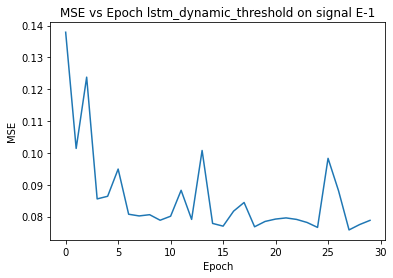

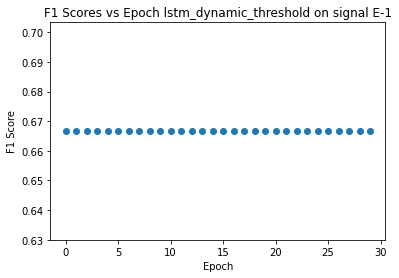

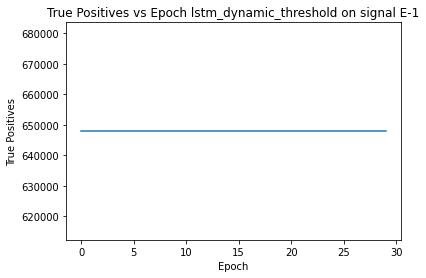

In [33]:
def get_lstm_data(signal_name, signal_id, dai_desk=False):
    plot_pipeline_mse_per_epoch(signal_name, 'lstm_dynamic_threshold', 30, signal_id, dai_desk)
    plot_pipeline_f1_scores_per_epoch(signal_name, 'lstm_dynamic_threshold', 30, signal_id, dai_desk)
    plot_pipeline_true_positives_per_epoch(signal_name, 'lstm_dynamic_threshold', 30, signal_id, dai_desk)

signal_name = "E-1"
signal_id = 1656783191
get_lstm_data(signal_name, signal_id)


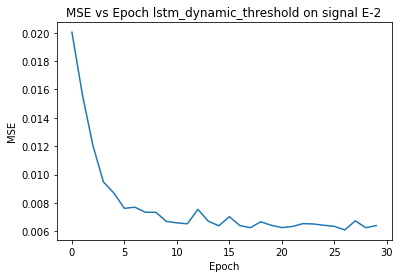

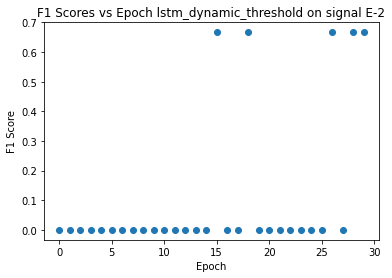

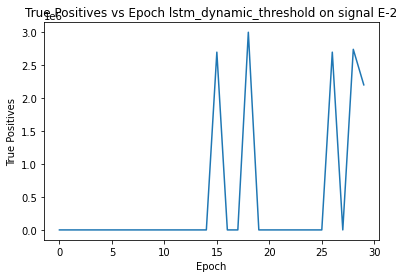

In [34]:
signal_name = "E-2"
signal_id = 1656793578
get_lstm_data(signal_name, signal_id, True)


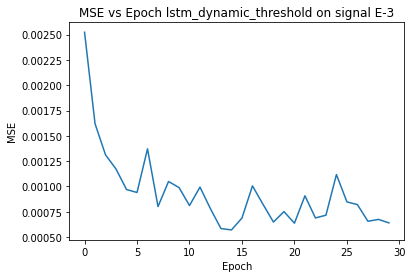

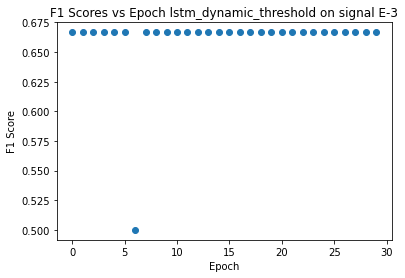

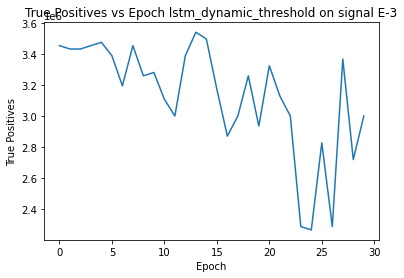

In [26]:
signal_name = "E-3"
signal_id = 1656805417
get_lstm_data(signal_name, signal_id)

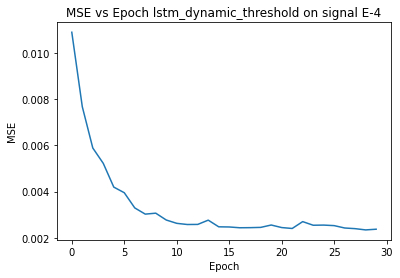

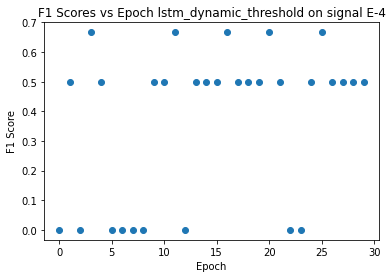

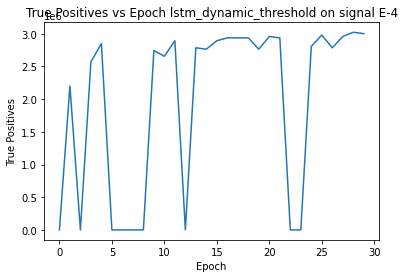

In [27]:
signal_name = "E-4"
signal_id = 1656810377
get_lstm_data(signal_name, signal_id)



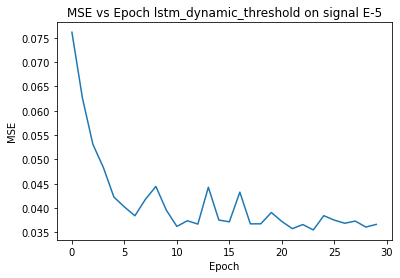

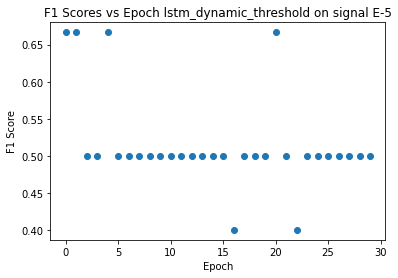

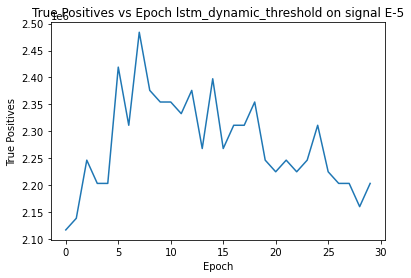

In [28]:
signal_name = "E-5"
signal_id = 1657215326
get_lstm_data(signal_name, signal_id)

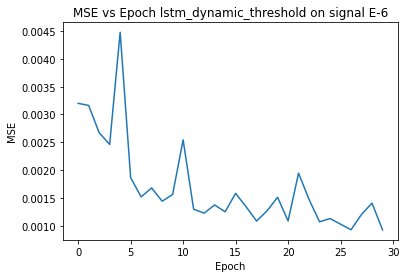

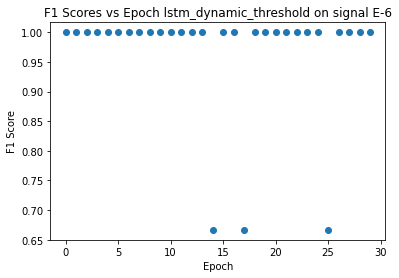

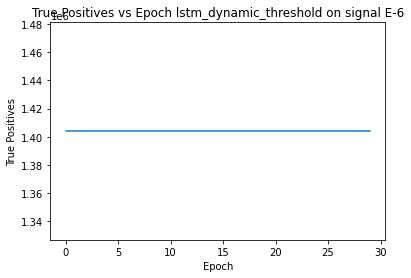

In [29]:
signal_name = "E-6"
signal_id = 1657309510
get_lstm_data(signal_name, signal_id)


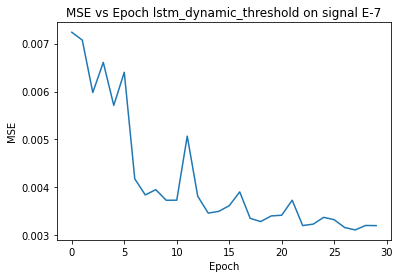

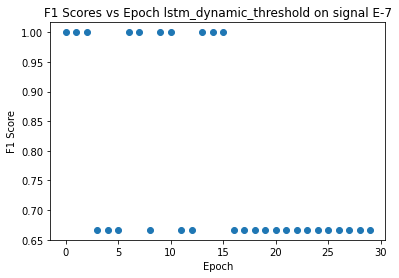

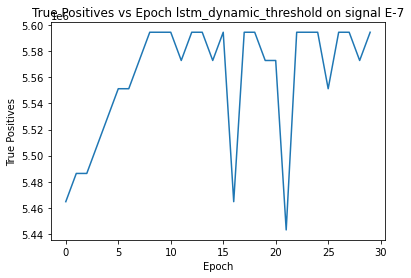

In [31]:
signal_name = "E-7"
signal_id = 1657315520
get_lstm_data(signal_name, signal_id, True)


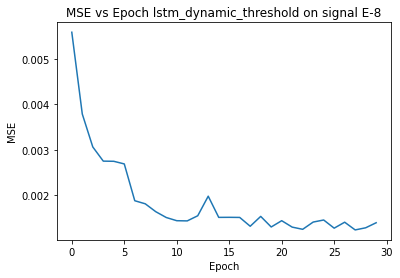

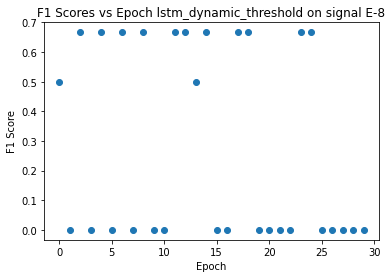

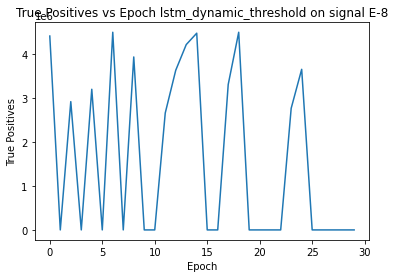

In [32]:
signal_name = "E-8"
signal_id = 1662672976
get_lstm_data(signal_name, signal_id, True)